# Congressmen notebook

Parses datasets/camara/congressmen_with_memberships.json creating / updating the following polare entites:
* Agents
* Memberships (Congress, Parties)
* Organizations (Camara)
* Posts (Camara)
* Roles (Afiliado, Deputado)

 ## 1. Imports and Constants Declaration

In [15]:
import json 
import pandas as pd
from collections import deque, defaultdict
from uuid import uuid4

from datetime import datetime
import matplotlib.pyplot as plt
import os

termid = 54 # legislatura
start_date = '2011-02-01'

PROV = 'cam'
JSON_PATH =  'datasets/camara/'
FILE_SUFFIX = termid
SUB_DIR = '{:}/'.format(termid)
BASE_PATH = 'datasets/slp/'
AGENTS_PATH = 'datasets/slp/agents/'
MEMBERSHIPS_PATH = 'datasets/slp/memberships/'
ORGANIZATIONS_PATH = 'datasets/slp/organizations/'
POSTS_PATH = 'datasets/slp/posts/'



CAMARA_URI = 'c8f660fd-7d0b-48e5-8513-2f7f0bb5f91c' 
DEPUTY_URI = '22a2ecf6-5f03-4da9-bc89-48319d152403' 
AFFILIATE_URI = '6a688541-b16a-45ca-8aa9-fa700373279f' 


 ## 2. Getting the Parties

In [16]:
filename = 'organizations.csv'
file_path = '{:}{:}'.format(BASE_PATH, filename)
df_parties = pd.read_csv(file_path, sep= ';', encoding= 'utf-8', index_col=None)
df_parties.set_index('sigla', inplace=True)


parties_d = df_parties['resource_uri'].to_dict()                        
print({k:parties_d[k]
    for k in ['PT', 'PMDB', 'DEM']})

{'PT': '7b2138a6-df61-11e7-baf1-c82a144c0a85', 'PMDB': '7b210cfa-df61-11e7-9864-c82a144c0a85', 'DEM': '7b20ed7e-df61-11e7-bb65-c82a144c0a85'}


## 3. Reads scrapped json

In [17]:
filename = 'congressman_with_memberships-{:}.json'.format(termid) 
file_path = '{:}{:}'.format(JSON_PATH, filename)
with open(file_path, mode='r') as f:
    congressmenstr = f.read()
f.close()

congressmen_with_memberships = json.loads(congressmenstr)

## 4. Agents

In [21]:
file_dir = '{:}{:}'.format(AGENTS_PATH, SUB_DIR)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

mapping = {
  'slp:resource_uri': 'slp:resource_uri',           
  'cam:ideCadastro': 'cam:ideCadastro',
  'cam:nomeCivil':'cam:nomeCivil',
  'cam:nomeParlamentarAtual':'cam:nomeParlamentarAtual',
  'cam:dataNascimento': 'cam:dataNascimento',
  'cam:dataFalecimento': 'cam:dataFalecimento',
}

agents = [] 
for cwm_d in congressmen_with_memberships:
    agent_d = {mapping[k]: cwm_d.get(k, None) for k in mapping}
    if agent_d:
        agents.append(agent_d)

filename = 'congressmen-{:}.csv'.format(PROV) 
file_path = '{:}{:}'.format(file_dir, filename)
df = pd.DataFrame.from_dict(agents)    
print('found {:} congressmen.'.format(df.shape[0]))
df.to_csv(file_path, sep=';', encoding='utf-8', index=None)
df.head()

found 671 congressmen.


,cam:dataFalecimento,cam:dataNascimento,cam:ideCadastro,cam:nomeCivil,cam:nomeParlamentarAtual,slp:resource_uri
0,None,1954-06-04,160559,ALCEU MOREIRA DA SILVA,ALCEU MOREIRA,None
1,None,1938-01-15,173269,AKIRA OTSUBO,AKIRA OTSUBO,None
2,None,1954-04-26,74696,ALBERTO PEREIRA MOURÃO,ALBERTO MOURÃO,None
3,None,1962-04-25,136811,JOSÉ ALFONSO EBERT HAMM,AFONSO HAMM,None
4,None,1950-01-08,178835,AFONSO ANTUNES DA MOTTA,AFONSO MOTTA,None


 ## 5. Congress Org
 
 ### 5.1 Membership Deputy

 #### 5.1.1 Process

In [12]:
mapping = {
    'cam:siglaUFRepresentacao': 'cam:siglaUFRepresentacao',
    'cam:dataInicio': 'cam:startDate', 
    'cam:dataFim': 'cam:finishDate',
    'slp:resource_uri':'slp:resource_uri'
}

memberships = [] 
for cwm_d in congressmen_with_memberships:
    member_uri = cwm_d['resource_uri'] 
    terms = cwm_d['terms']
    if terms:
        for term_d in terms:
            memberships_d = {mapping[k]: term_d.get(k, None) for k in mapping}
            if memberships_d:
                memberships_d['org:member'] = member_uri
                memberships_d['org:role'] = DEPUTY_URI
                memberships.append(memberships_d)


memberships = sorted(memberships, key=lambda x:x['cam:startDate'])
df = pd.DataFrame.from_dict(memberships)    
print('number of memberships:{:}'.format(df.shape[0]))
df.head()            

number of memberships:964


,cam:finishDate,cam:siglaUFRepresentacao,cam:startDate,org:member,org:role,slp:resource_uri
0,2015-01-31,RS,2011-02-01,e38a5721-8e42-4166-acdf-e86691815fed,22a2ecf6-5f03-4da9-bc89-48319d152403,30a9cd23-b515-430d-a59e-5a5c35d41498
1,2015-01-31,RS,2011-02-01,5482441d-97dc-4cff-a6c8-8cfde80b3a3d,22a2ecf6-5f03-4da9-bc89-48319d152403,aa72d5da-97e7-4970-913f-50d8e4d83e0a
2,2011-10-31,SP,2011-02-01,8a00a87d-86d9-4a37-b73e-7ebe58ccda92,22a2ecf6-5f03-4da9-bc89-48319d152403,0c2eda2d-0959-4892-8b2b-10aca587b8eb
3,2015-01-31,MG,2011-02-01,19f48d20-2e53-4265-a474-64fc6218625e,22a2ecf6-5f03-4da9-bc89-48319d152403,0d5d2085-f8b1-4698-a72c-6fe64f419d04
4,2015-01-31,PR,2011-02-01,7f05e4dd-4070-4dde-ad79-ad7ac97f7dc6,22a2ecf6-5f03-4da9-bc89-48319d152403,1938d58a-d22d-49d8-a396-c69eb73c0089


#### 5.1.2 Save

In [22]:
file_dir = '{:}{:}'.format(MEMBERSHIPS_PATH, SUB_DIR)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

filename = 'memberships_at_congress-{:}.csv'.format(PROV, FILE_SUFFIX) 
file_path = '{:}{:}'.format(file_dir, filename)
df.to_csv(file_path, sep=';', encoding='utf-8', index=None)

 ### 5.3 Post Deputy

 #### 5.3.1 Preprocess

There are currently 513 Posts at Camara. The total should be fixed but in practice it's not. Our first task is to determine the max number of posts and then allocating them accordingly.

In [23]:
memberships = sorted(memberships, key=lambda x:x['cam:startDate'])
df = pd.DataFrame.from_dict(memberships)  

def cumsum(lis):
    total = 0
    for x in lis:
        total += x
        yield total
        
ts_open = pd.pivot_table(df, index='cam:startDate',aggfunc=len)['cam:finishDate']
ts_open.index.names = ['time']
ts_open.name = 'new'

ts_close = pd.pivot_table(df, index='cam:finishDate',aggfunc=len)['cam:startDate']
ts_close.index.names = ['time']
ts_close.name = 'expired'

df = ts_open.to_frame().join(ts_close.to_frame(), how='outer').fillna(0)
df['total'] = list(cumsum(df['new'] - df['expired']))
print('Max posts:', max(df['total']))
df.head()




Max posts: 522.0


,new,expired,total
time,,,
2011-02-01,517.0,0.0,517.0
2011-02-02,4.0,15.0,506.0
2011-02-03,10.0,10.0,506.0
2011-02-04,7.0,4.0,509.0
2011-02-07,2.0,1.0,510.0


 #### 5.3.1 Posts graph

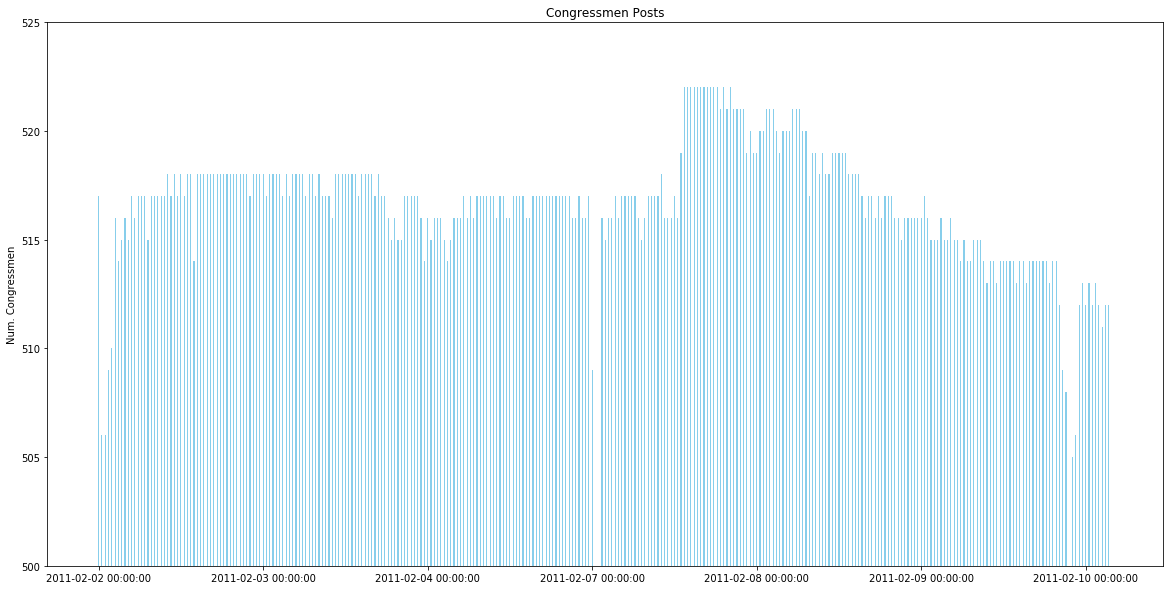

In [24]:
# from datetime import datetime
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(20, 10))
ind = range(df.shape[0])
width = 0.35  # the width of the bars
fromDate = datetime.strptime(df.index[0], '%Y-%m-%d')
toDate = datetime.strptime(df.index[1], '%Y-%m-%d')
xticks = [ datetime.strptime(dt, '%Y-%m-%d') for dt in df.index ]

rects1 = ax.bar(ind, df['total'].values, width=width, color='SkyBlue')
ax.set_ylabel('Num. Congressmen')
ax.set_title('Congressmen Posts')
ax.set_xticklabels(xticks)
plt.ylim([500, 525])
plt.show()


 #### 5.3.2 Posts allocation
 
 We create a queue of posts and allocate them as necessary.

In [25]:
maxlen= int(max(df['total']))
posts = deque([str(uuid4()) for _ in range(maxlen)], maxlen=maxlen)
posts_expired = defaultdict(deque)

# Sort by dataInicio 
memberships = sorted(memberships, key=lambda x:x['cam:startDate'])
dates = df.index.tolist()
prevdate = '1800-01-01'
for d in memberships:
    start = d['cam:startDate']
    finish = d['cam:finishDate']
    # either the start date is in posts_expired
    # or some posts have become available
    processdates = [date for date in dates 
                         if date >= prevdate and date <= start]        
    for procdate in processdates:
        if procdate in posts_expired:
            try:
                # pops from expired until empty
                while True:      
                    post_uri = posts_expired[procdate].pop()
                    posts.append(post_uri)
            except IndexError: 
                i=0
    
    post_uri = posts.pop()
    d['org:post'] = str(uuid4())
    if finish: # push for a future date        
        posts_expired[finish].append(d['org:post'])
    prevdate = start


df = pd.DataFrame.from_dict(memberships)    
df.head()

,cam:finishDate,cam:siglaUFRepresentacao,cam:startDate,org:member,org:post,org:role,slp:resource_uri
0,2015-01-31,RS,2011-02-01,e38a5721-8e42-4166-acdf-e86691815fed,c32b2047-7a11-46e5-a836-92618930d04a,22a2ecf6-5f03-4da9-bc89-48319d152403,30a9cd23-b515-430d-a59e-5a5c35d41498
1,2015-01-31,RS,2011-02-01,5482441d-97dc-4cff-a6c8-8cfde80b3a3d,6b372099-1563-4050-ab4c-61ec28d6aaeb,22a2ecf6-5f03-4da9-bc89-48319d152403,aa72d5da-97e7-4970-913f-50d8e4d83e0a
2,2011-10-31,SP,2011-02-01,8a00a87d-86d9-4a37-b73e-7ebe58ccda92,061dc2e1-8970-4209-9cce-79cfa521dfb8,22a2ecf6-5f03-4da9-bc89-48319d152403,0c2eda2d-0959-4892-8b2b-10aca587b8eb
3,2015-01-31,MG,2011-02-01,19f48d20-2e53-4265-a474-64fc6218625e,60d51106-95d1-40be-a823-647e97b07b73,22a2ecf6-5f03-4da9-bc89-48319d152403,0d5d2085-f8b1-4698-a72c-6fe64f419d04
4,2015-01-31,PR,2011-02-01,7f05e4dd-4070-4dde-ad79-ad7ac97f7dc6,4b711698-c57f-4f54-84ee-ad18652996ea,22a2ecf6-5f03-4da9-bc89-48319d152403,1938d58a-d22d-49d8-a396-c69eb73c0089


 #### 5.3.3 Posts unique

In [26]:
df = df[['org:post','org:role']] 
df.drop_duplicates(subset=['org:post','org:role'], keep='first', inplace=True)
df = df.rename({'org:post':'slp:resource_uri'}, axis='columns')
df['org:postIn'] = CAMARA_URI
print('Roles and Posts unique tuples:', df.shape[0])

df.head()

Roles and Posts unique tuples: 964


,slp:resource_uri,org:role,org:postIn
0,c32b2047-7a11-46e5-a836-92618930d04a,22a2ecf6-5f03-4da9-bc89-48319d152403,c8f660fd-7d0b-48e5-8513-2f7f0bb5f91c
1,6b372099-1563-4050-ab4c-61ec28d6aaeb,22a2ecf6-5f03-4da9-bc89-48319d152403,c8f660fd-7d0b-48e5-8513-2f7f0bb5f91c
2,061dc2e1-8970-4209-9cce-79cfa521dfb8,22a2ecf6-5f03-4da9-bc89-48319d152403,c8f660fd-7d0b-48e5-8513-2f7f0bb5f91c
3,60d51106-95d1-40be-a823-647e97b07b73,22a2ecf6-5f03-4da9-bc89-48319d152403,c8f660fd-7d0b-48e5-8513-2f7f0bb5f91c
4,4b711698-c57f-4f54-84ee-ad18652996ea,22a2ecf6-5f03-4da9-bc89-48319d152403,c8f660fd-7d0b-48e5-8513-2f7f0bb5f91c


 #### 5.3.3  Congress Posts Save

In [22]:
filename = 'posts_at_congress-{:}.csv'.format(PROV) 
file_path = '{:}{:}{:}'.format(POSTS_PATH, SUB_DIR, filename)
df.to_csv(file_path, sep=';', encoding='utf-8', index=None)

 ## 6. Party Org

 ### 6.1 Membership Affiliation
 
 ### 6.1.1 Process

In [23]:
mapping = {
    'cam:sigla': 'cam:sigla',
    'cam:dataInicio': 'cam:startDate', 
    'cam:dataFim': 'cam:finishDate',
    'slp:resource_uri':'slp:resource_uri'
}

memberships = [] 
for cwm_d in congressmen_with_memberships:
    member_uri = cwm_d['slp:resource_uri'] 
    affiliations = cwm_d['affiliations']
    if affiliations:
        for affiliation_d in affiliations:
            memberships_d = {mapping[k]: affiliation_d.get(k, None) for k in mapping}
            if memberships_d:
                memberships_d['org:member'] = member_uri
                memberships_d['org:role'] = AFFILIATE_URI
                memberships.append(memberships_d)


df = pd.DataFrame.from_dict(memberships)   
df.head()

,cam:finishDate,cam:sigla,cam:startDate,org:member,org:role,slp:resource_uri
0,None,PRB,None,64965d06-916a-4ef9-a8c7-886055dc979e,6a688541-b16a-45ca-8aa9-fa700373279f,fe42e2cd-dfab-43be-be18-cb88180637fe
1,None,DEM,None,64965d06-916a-4ef9-a8c7-886055dc979e,6a688541-b16a-45ca-8aa9-fa700373279f,db643c02-6940-41c0-b668-fee9d4ae20b4
2,None,PP,None,908bcac7-6fc7-4957-9ae9-00a46ad10a37,6a688541-b16a-45ca-8aa9-fa700373279f,f5193800-cd60-453b-b9c2-add0ec7f27d3
3,None,PMDB,None,5ff9cfe9-2fee-47b6-b7ac-a1cb282236be,6a688541-b16a-45ca-8aa9-fa700373279f,e6279cfe-789b-49c5-959a-49f14bea2571
4,None,PT,None,e4e93a22-8177-400a-8231-2e8ae9d06a12,6a688541-b16a-45ca-8aa9-fa700373279f,3bc84a72-bbf1-4cda-8833-7e94d7c8b234


 ### 6.1.2 Save

In [24]:
filename = 'memberships_at_parties-{:}.csv'.format(PROV) 
file_path = '{:}{:}{:}'.format(MEMBERSHIPS_PATH, SUB_DIR, filename)
df.to_csv(file_path, sep=';', encoding='utf-8', index=None)

### 6.3 Posts at Parties

#### 6.3.1 Process

In [25]:
df = df.rename({'slp:resource_uri':'org:role'}, axis='columns')
df['slp:resource_uri'] = [uuid4() for _ in range(df.shape[0])]
df['org:postIn'] = [parties_d.get(mem['cam:sigla'], None) for mem in memberships]
df.drop('rdfs:label', axis=1,inplace=True)
df.head()


,cam:finishDate,cam:sigla,cam:startDate,org:member,org:role,org:role,slp:resource_uri,org:postIn
0,None,PRB,None,64965d06-916a-4ef9-a8c7-886055dc979e,6a688541-b16a-45ca-8aa9-fa700373279f,fe42e2cd-dfab-43be-be18-cb88180637fe,d37dcf09-129b-4ef3-8488-b96ab24aa0e8,7b211b34-df61-11e7-b235-c82a144c0a85
1,None,DEM,None,64965d06-916a-4ef9-a8c7-886055dc979e,6a688541-b16a-45ca-8aa9-fa700373279f,db643c02-6940-41c0-b668-fee9d4ae20b4,12dabcc1-6fc0-4cff-9024-f3fa1368ada3,7b20ed7e-df61-11e7-bb65-c82a144c0a85
2,None,PP,None,908bcac7-6fc7-4957-9ae9-00a46ad10a37,6a688541-b16a-45ca-8aa9-fa700373279f,f5193800-cd60-453b-b9c2-add0ec7f27d3,a4259e2e-f473-4bb8-9511-c07842a701f3,7b21152e-df61-11e7-bdcf-c82a144c0a85
3,None,PMDB,None,5ff9cfe9-2fee-47b6-b7ac-a1cb282236be,6a688541-b16a-45ca-8aa9-fa700373279f,e6279cfe-789b-49c5-959a-49f14bea2571,42193783-26cd-4631-b569-a8ff67833e4c,7b210cfa-df61-11e7-9864-c82a144c0a85
4,None,PT,None,e4e93a22-8177-400a-8231-2e8ae9d06a12,6a688541-b16a-45ca-8aa9-fa700373279f,3bc84a72-bbf1-4cda-8833-7e94d7c8b234,46d99f39-cb6b-4d57-831a-3971cb4a2e2e,7b2138a6-df61-11e7-baf1-c82a144c0a85


#### 6.3.2 Save

In [26]:
filename = 'posts_at_parties-{:}.csv'.format(PROV) 
file_path = '{:}{:}{:}'.format(POSTS_PATH, SUB_DIR, filename)
df.to_csv(file_path, sep=';', encoding='utf-8', index=None)